In [45]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import tmtools
import os

from tmtools.io import get_structure, get_residue_data
from tmtools import tm_align
from iglm import IgLM
from safetensors.torch import load_file
from esm.models.esm3 import ESM3
from transformers import AutoModel
from esm.sdk.api import ESMProtein, GenerationConfig
from matplotlib import pyplot as plt
from nltk.metrics import edit_distance
from tqdm import tqdm
from antiberty import AntiBERTyRunner

<Chain id=H>
<Chain id=L>


In [2]:
base_model = ESM3.from_pretrained("esm3-open", device=torch.device("cuda:0"))
finetuned_model = ESM3.from_pretrained("esm3-open", device=torch.device("cuda:0"))

Fetching 22 files: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 61434.55it/s]
/home/av47/miniconda3/envs/esm/lib/python3.12/site-packages/esm/pretrained.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` f

In [3]:
def load_weights(path, model):
    state_dict = torch.load(path, map_location="cuda:0")
    new_dict = {}
    
    for k, v in state_dict.items():
        if k in model.state_dict():
            new_dict[k] = v
    model.load_state_dict(new_dict)

In [4]:
load_weights("weights/20241201-144617/checkpoint-46362/pytorch_model.bin", finetuned_model)

/tmp/ipykernel_3914019/3178905372.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location="cuda:0")


In [12]:
def fold_sequence(sequence, model, save_dir):
    prompt = f"EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYC{sequence}WGQGTLVTVSS"
    protein = ESMProtein(sequence=prompt)
    protein = model.generate(protein, GenerationConfig(track="structure", num_steps=8))
    protein.to_pdb(f"{save_dir}/{sequence}.pdb")

In [47]:
for file in os.listdir("outputs/ABodyBuilder2_pdb"):
    fold_sequence(file[:-4], base_model, "outputs/esm_pdb/base")
    fold_sequence(file[:-4], finetuned_model, "outputs/esm_pdb/finetuned")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 23.76it/s]


In [62]:
base_rmsd = []
finetuned_rmsd = []

for file in os.listdir("outputs/ABodyBuilder2_pdb"):
    template_struct = get_structure(f"outputs/ABodyBuilder2_pdb/{file}")
    template_chain = next(template_struct.get_chains())
    template_coords, template_seq = get_residue_data(template_chain)

    base_struct = get_structure(f"outputs/esm_pdb/base/{file}")
    base_chain = next(base_struct.get_chains())
    base_coords, base_seq = get_residue_data(base_chain)

    finetuned_struct = get_structure(f"outputs/esm_pdb/finetuned/{file}")
    finetuned_chain = next(finetuned_struct.get_chains())
    finetuned_coords, finetuned_seq = get_residue_data(finetuned_chain)
    
    base_res = tm_align(template_coords[96:106], base_coords[96:106], template_seq[96:106], base_seq[96:106])
    finetuned_res = tm_align(template_coords[96:106], finetuned_coords[96:106], template_seq[96:106], finetuned_seq[96:106])
    
    base_rmsd.append(base_res.rmsd)
    finetuned_rmsd.append(finetuned_res.rmsd)

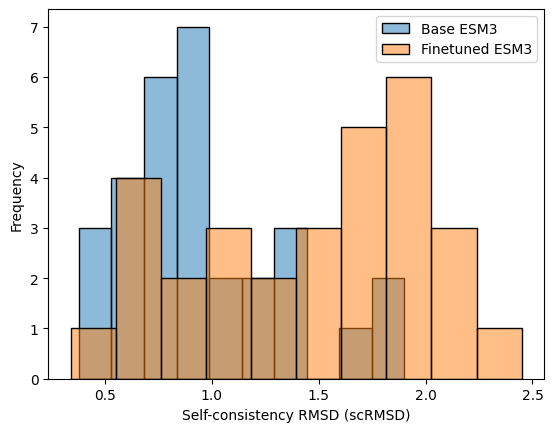

In [68]:
sns.histplot(base_rmsd, bins=10, alpha=0.5, label="Base ESM3")
sns.histplot(finetuned_rmsd, bins=10, alpha=0.5, label="Finetuned ESM3")
plt.xlabel("Self-consistency RMSD (scRMSD)")
plt.ylabel("Frequency")
plt.legend()
plt.show()